In [103]:
# Workspace problem with several narrow gaps

import torch
import torch.nn as nn
from torch.nn.modules import loss
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random
import time

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

In [104]:
# neural network parameters
mb_size = 256 # mini batch dim
h_Q_dim = 512 # encoder dim
h_P_dim = 512 # decoder dim

c = 0 # unsure of this constant
lr = 1e-4 # learning rate

# problem dimenc_dimsions
dim = 6 # (x, xdot, y, ydot, z, zdot)
dataElements = dim+3*3+2*dim # sample (6D), gap1 (2D, 1D orientation), gap2, gap3, init (6D), goal (6D)

z_dim = 3 # latent dim
X_dim = dim # samples dim
y_dim = dim # reconstruction of the original point (unsused?)
c_dim = dataElements - dim # dimension of conditioning variable

In [105]:
# read in data from csv
filename = 'narrowDataFile.txt'
f = open(filename, 'rt')
reader = csv.reader(f, delimiter=',')
count = 0
data_list = []
for row in reader:
    data_list.append(list(map(float,row[0:dataElements]))) # use list() with python 3

data = np.array(data_list,dtype='d') # shape = [numEntries, dataElements]
numEntries = data.shape[0]

In [106]:
# split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)
ratioTestTrain = 0.8;
numTrain = int(numEntries*ratioTestTrain)

X_train = data[0:numTrain,0:dim] # samples state: x, y, z, xdot, ydot, zdot
c_train = data[0:numTrain,dim:dataElements] # conditions: gaps, init (6), goal (6)

X_test = data[numTrain:numEntries,0:dim]
c_test = data[numTrain:numEntries,dim:dataElements]
numTest = X_test.shape[0]

In [107]:
# change conditions to occupancy grid
def isSampleFree(sample, obs):
    for o in list(range(0,obs.shape[0]//(2*dimW))): # python 2 -> 3: use list(), use //
        isFree = 0
        for d in range(0,sample.shape[0]):
            if (sample[d] < obs[2*dimW*o + d] or sample[d] > obs[2*dimW*o + d + dimW]):
                isFree = 1
                break
        if isFree == 0:
            return 0
    return 1

gridSize = 11
dimW = 3
plotOn = False;

# process data into occupancy grid
conditions = data[0:numEntries,dim:dataElements]
conditionsOcc = np.zeros([numEntries,gridSize*gridSize])
occGridSamples = np.zeros([gridSize*gridSize, 2])
gridPointsRange = np.linspace(0,1,num=gridSize)

idx = 0;
for i in gridPointsRange:
    for j in gridPointsRange:
        occGridSamples[idx,0] = i
        occGridSamples[idx,1] = j
        idx += 1;

start = time.time();
for j in range(0,numEntries,1):
    dw = 0.1
    dimW = 3
    gap1 = conditions[j,0:3]
    gap2 = conditions[j,3:6]
    gap3 = conditions[j,6:9]
    init = conditions[j,9:15]
    goal = conditions[j,15:21]

    obs1 = [0, gap1[1]-dw, -0.5,             gap1[0], gap1[1], 1.5]
    obs2 = [gap2[0]-dw, 0, -0.5,             gap2[0], gap2[1], 1.5];
    obs3 = [gap2[0]-dw, gap2[1]+dw, -0.5,    gap2[0], 1, 1.5];
    obs4 = [gap1[0]+dw, gap1[1]-dw, -0.5,    gap3[0], gap1[1], 1.5];
    obs5 = [gap3[0]+dw, gap1[1]-dw, -0.5,    1, gap1[1], 1.5];
    obs = np.concatenate((obs1, obs2, obs3, obs4, obs5), axis=0)
    
    if j % 5000 == 0:
        print('Iter: {}'.format(j))
        
    occGrid = np.zeros(gridSize*gridSize)
    for i in range(0,gridSize*gridSize):
        occGrid[i] = isSampleFree(occGridSamples[i,:],obs)
    conditionsOcc[j,:] = occGrid
    
    if plotOn:
        fig1 = plt.figure(figsize=(10,6), dpi=80)
        ax1 = fig1.add_subplot(111, aspect='equal')
        for i in range(0,obs.shape[0]/(2*dimW)): # plot obstacle patches
            ax1.add_patch(
            patches.Rectangle(
                (obs[i*2*dimW], obs[i*2*dimW+1]),       # (x,y)
                obs[i*2*dimW+dimW] - obs[i*2*dimW],     # width
                obs[i*2*dimW+dimW+1] - obs[i*2*dimW+1], # height
                alpha=0.6
            ))
        for i in range(0,gridSize*gridSize): # plot occupancy grid
            if occGrid[i] == 0:
                plt.scatter(occGridSamples[i,0], occGridSamples[i,1], color="red", s=70, alpha=0.8)
            else:
                plt.scatter(occGridSamples[i,0], occGridSamples[i,1], color="green", s=70, alpha=0.8)
        plt.show()
end = time.time();
print('Time: ', end-start)
    
cs = np.concatenate((data[0:numEntries,dim+3*dimW:dataElements], conditionsOcc), axis=1) # occ(11x11), init (6D), goal (6D)
c_dim = cs.shape[1]
c_gapsInitGoal = c_test
c_train = cs[0:numTrain,:] 
c_test = cs[numTrain:numEntries,:]

Iter: 0
Iter: 5000
Iter: 10000
Iter: 15000
Iter: 20000
Iter: 25000
Iter: 30000
Iter: 35000
Iter: 40000
Iter: 45000
Iter: 50000
Iter: 55000
Iter: 60000
Iter: 65000
Iter: 70000
Iter: 75000
Iter: 80000
Time:  29.835837364196777


In [108]:
# define pytorch networks
# based on https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/.ipynb_checkpoints/01_Variational_AutoEncoder-checkpoint.ipynb

class Encoder(nn.Module):
    
    def __init__(self, input_dim=X_dim+c_dim, hidden_dim=h_Q_dim, latent_dim=z_dim):
        super(Encoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.z_mu = nn.Linear(hidden_dim, latent_dim)
        self.z_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):

        seq = self.network(x)

        return self.z_mu(seq), self.z_logvar(seq)


class Decoder(nn.Module):
    def __init__(self, latent_dim=z_dim+c_dim, hidden_dim=h_P_dim, output_dim=X_dim):
        super(Decoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        
        return self.network(x)


class NeuralNetwork(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(NeuralNetwork, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
    
    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(mean).to(DEVICE)        # sampling epsilon        
        z = mean + torch.exp(0.5 * logvar) * epsilon       # reparameterization trick
        return z

    def forward(self, x, c, encode=True):
        if encode:
            z_mu, z_logvar = self.Encoder(torch.cat((x, c), dim=1))
            z = self.reparameterization(z_mu, z_logvar)

            y = self.Decoder(torch.cat((z, c), dim=1))
            
            return y, z_mu, z_logvar
        else:
            z = x
            y = self.Decoder(torch.cat((z, c), dim=1))    

            return y


encoder = Encoder()
decoder = Decoder()
network = NeuralNetwork(Encoder=encoder, Decoder=decoder).to(DEVICE)

weight = torch.tensor([1, 1, 1, 0.5, 0.5, 0.5], requires_grad=False, dtype=torch.float32, device=DEVICE)

def loss_function(x, y, mean, logvar):
    recon_loss = (weight * (x - y) ** 2).mean()
    kl_loss    = 10**-4 * 2 * torch.sum(torch.exp(logvar) + mean.pow(2) - 1. - logvar, dim=1)

    return torch.mean(kl_loss + recon_loss)

optimizer = optim.Adam(network.parameters(), lr=lr)


In [109]:

# Training
for it in range(500001):
    # randomly generate batches
    batch_elements = [randint(0,numTrain-1) for n in range(0,mb_size)]

    X_mb = torch.tensor(X_train[batch_elements,:], requires_grad=True, dtype=torch.float32, device=DEVICE)
    c_mb = torch.tensor(c_train[batch_elements,:], requires_grad=True, dtype=torch.float32, device=DEVICE)

    optimizer.zero_grad()

    y, z_mu, z_logvar = network(X_mb, c_mb)
    
    loss = loss_function(X_mb, y, z_mu, z_logvar)
    loss.backward()
    optimizer.step()

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()


Iter: 0
Loss: 0.2389

Iter: 1000
Loss: 0.03166

Iter: 2000
Loss: 0.02709

Iter: 3000
Loss: 0.02428

Iter: 4000
Loss: 0.0231

Iter: 5000
Loss: 0.02103

Iter: 6000
Loss: 0.02073

Iter: 7000
Loss: 0.02017

Iter: 8000
Loss: 0.01825

Iter: 9000
Loss: 0.01897

Iter: 10000
Loss: 0.01864

Iter: 11000
Loss: 0.01764

Iter: 12000
Loss: 0.01715

Iter: 13000
Loss: 0.0158

Iter: 14000
Loss: 0.01608

Iter: 15000
Loss: 0.01617

Iter: 16000
Loss: 0.01464

Iter: 17000
Loss: 0.01438

Iter: 18000
Loss: 0.01378

Iter: 19000
Loss: 0.0144

Iter: 20000
Loss: 0.01354

Iter: 21000
Loss: 0.01503

Iter: 22000
Loss: 0.01331

Iter: 23000
Loss: 0.01444

Iter: 24000
Loss: 0.01437

Iter: 25000
Loss: 0.01297

Iter: 26000
Loss: 0.01378

Iter: 27000
Loss: 0.0139

Iter: 28000
Loss: 0.01295

Iter: 29000
Loss: 0.01322

Iter: 30000
Loss: 0.01269

Iter: 31000
Loss: 0.01294

Iter: 32000
Loss: 0.01303

Iter: 33000
Loss: 0.01329

Iter: 34000
Loss: 0.0132

Iter: 35000
Loss: 0.01297

Iter: 36000
Loss: 0.01236

Iter: 37000
Loss: 0.

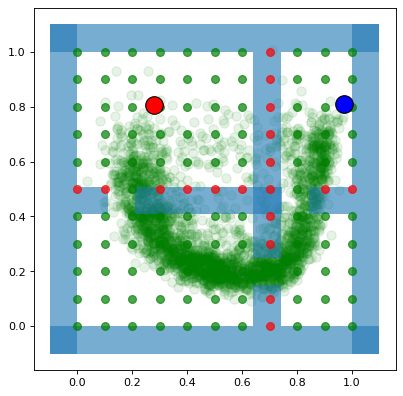

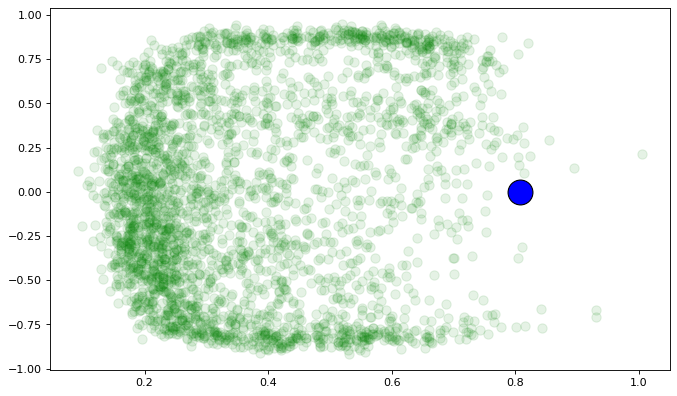

In [124]:
# plot the latent space
num_viz = 3000 # number of samples to draw in latent space

vizIdx = randint(0,numTest-1); # chose a random test scenario

c_sample_seed = c_test[vizIdx,:]
c_sample = torch.from_numpy(np.repeat([c_sample_seed],num_viz,axis=0)).float().to(DEVICE)
c_viz = c_gapsInitGoal[vizIdx,:]

# directly sample from the latent space (preferred, what we will use in the end)
y_viz = network(torch.randn(num_viz, z_dim).to(DEVICE), c_sample, encode=False).cpu().detach().numpy()
# y_viz is sample in state space (6D), zviz in latent space (3D)

fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect='equal')

plt.scatter(y_viz[:,0],y_viz[:,1], color="green", s=70, alpha=0.1)

dw = 0.1
dimW = 3
gap1 = c_viz[0:3]
gap2 = c_viz[3:6]
gap3 = c_viz[6:9]
init = c_viz[9:15]
goal = c_viz[15:21]

obs1 = [0, gap1[1]-dw, -0.5,             gap1[0], gap1[1], 1.5]
obs2 = [gap2[0]-dw, 0, -0.5,             gap2[0], gap2[1], 1.5];
obs3 = [gap2[0]-dw, gap2[1]+dw, -0.5,    gap2[0], 1, 1.5];
obs4 = [gap1[0]+dw, gap1[1]-dw, -0.5,    gap3[0], gap1[1], 1.5];
obs5 = [gap3[0]+dw, gap1[1]-dw, -0.5,    1, gap1[1], 1.5];
obsBounds = [-0.1, -0.1, -0.5, 0, 1.1, 1.5,
            -0.1, -0.1, -0.5, 1.1, 0, 1.5,
            -0.1, 1, -0.5, 1.1, 1.1, 1.5,
            1, -0.1, -0.5, 1.1, 1.1, 1.5,]

obs = np.concatenate((obs1, obs2, obs3, obs4, obs5, obsBounds), axis=0)
for i in list(range(0,obs.shape[0]//(2*dimW))): # list() and //
    ax1.add_patch(
    patches.Rectangle(
        (obs[i*2*dimW], obs[i*2*dimW+1]),   # (x,y)
        obs[i*2*dimW+dimW] - obs[i*2*dimW],          # width
        obs[i*2*dimW+dimW+1] - obs[i*2*dimW+1],          # height
        alpha=0.6
    ))
    
for i in list(range(0,gridSize*gridSize)): # plot occupancy grid | list() and //
    cIdx = i + 2*dim
    if c_sample_seed[cIdx] == 0:
        plt.scatter(occGridSamples[i,0], occGridSamples[i,1], color="red", s=50, alpha=0.7)
    else:
        plt.scatter(occGridSamples[i,0], occGridSamples[i,1], color="green", s=50, alpha=0.7)

plt.scatter(init[0], init[1], color="red", s=250, edgecolors='black') # init
plt.scatter(goal[0], goal[1], color="blue", s=250, edgecolors='black') # goal

plt.show()

plt.figure(figsize=(10,6), dpi=80)
viz1 = 1;
viz2 = 4;
plt.scatter(y_viz[:,viz1],y_viz[:,viz2], color="green", s=70, alpha=0.1)
plt.scatter(c_viz[viz1+9],c_viz[viz2+9], color="red", s=250, edgecolors='black') # init
plt.scatter(c_viz[viz1+9+dim],c_viz[viz2+9+dim], color="blue", s=500, edgecolors='black') # goal
plt.show()